<a href="https://colab.research.google.com/github/thescalableguy/Machine_Learning_Notebooks/blob/main/Machine_Unlearning_Data_Obfuscation_Transformers_CapstoneProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Unlearning with Data Obfuscation

```
Problem Statement: Transformer-based model (e.g., BERT) for NLP tasks like classification or question answering
```

**Model Selection:**
*   Why Transformer: State-of-the-art for text understanding.
*   Pretrained model: Use Hugging Face bert-base-uncased for transfer learning
*   Use case: Sentiment classification, topic classification, etc.




In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import os
import timm
from huggingface_hub import notebook_login

In [4]:
!pip install nbstripout

In [8]:
!nbstripout --install

fatal: --local can only be used inside a git repository
Installation failed: not a git repository!


# Device Configuration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Configuration

In [ ]:
NUM_CLASSES = 10
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# Adding Hugging Face Token

Add your hugging face token here

# Model Architecture

```
[CLS] → BERT Embedding → Transformer Blocks → [CLS] token → Dense(1 or num_classes)

```
*   Pretrained BERT → Classification head

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, NUM_CLASSES)

In [ ]:
# --- Instantiate the Model ---
model = model.to(device)
print("Model Architecture:")
print(model)

Model Architecture:
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
     

# Data Pre-Processing



*   Tokenization using BERT tokenizer
*   Convert text to input IDs, attention masks
*   Label encoding (e.g., 0 = negative, 1 = positive)
*   Resizing Images to be understood by transformer

In [ ]:
print("\nLoading CIFAR-10 data...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


Loading CIFAR-10 data...


In [ ]:
# Download and load the training data
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Download and load the test data
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle test data

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

100%|██████████| 170M/170M [00:04<00:00, 42.0MB/s]


Training samples: 50000
Test samples: 10000
Number of training batches: 782
Number of test batches: 157


# Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam optimizer

print(f"\nOptimizer: Adam, Learning Rate: {LEARNING_RATE}")
print(f"Loss Function: CrossEntropyLoss")


Optimizer: Adam, Learning Rate: 0.001
Loss Function: CrossEntropyLoss


# Model Training

In [ ]:
print(f"\nStarting Training for {NUM_EPOCHS} epochs...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # --- Forward Pass ---
        outputs = model(images)
        loss = criterion(outputs, labels)

        # --- Backward Pass and Optimize ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- Track Statistics ---
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate epoch statistics
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    print(f'--- Epoch [{epoch+1}/{NUM_EPOCHS}] Completed ---')
    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')


training_time = time.time() - start_time
print(f"\nTraining finished in {training_time:.2f} seconds.")

# Save the trained model
torch.save(model.state_dict(), 'timm_cifar10_pytorch.pth')
print("Trained model state dictionary saved to timm_cifar10_pytorch.pth")


Starting Training for 10 epochs...


# Model Evaluation

In [ ]:
print("\n--- Evaluating Model on Test Set ---")
model.eval()
all_preds = []
all_labels = []

# No need to track gradients during evaluation
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)  # Forward pass

        # Max k calculation: value, index
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        # Store predictions and labels for detailed metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate overall test accuracy
test_acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network on the {len(test_dataset)} test images: {test_acc:.2f} %')

# --- Detailed Evaluation Metrics (using sklearn) ---
print("\n--- Detailed Evaluation Metrics ---")
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(NUM_CLASSES)])
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Overall Test Accuracy (sklearn): {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set - PyTorch Training)')
plt.show()

print("\nEvaluation complete.")

# Unlearn Configuration

In [ ]:
CLASS_TO_UNLEARN_NAME = 'dog'
CLASS_TO_UNLEARN = train_dataset_full.class_to_idx[CLASS_TO_UNLEARN_NAME]
NUM_CLASSES = 10
OBFUSCATION_METHOD = 'label_randomization' # Options: 'label_randomization', 'add_noise', 'replace_with_noise'
NOISE_FACTOR = 0.6 # Used if OBFUSCATION_METHOD is 'add_noise'
FINETUNE_EPOCHS = 10
FINETUNE_LR = 1e-5 # Use a low learning rate for fine-tuning
BATCH_SIZE = 64

# Device Configuration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Load Pre-trained Model

In [ ]:
print("Loading pre-trained model (or initializing placeholder)...")
model1 = timm.create_model('vit_base_patch16_224', pretrained=True)
model1.head = nn.Linear(model.head.in_features, NUM_CLASSES)
model1.load_state_dict(torch.load('timm_cifar10_pytorch.pth', map_location=device))
print("Model loaded (or placeholder initialized).")
print(model1)

Loading pre-trained model (or initializing placeholder)...
Model loaded (or placeholder initialized).
CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


# Data Pre-Processing

In [ ]:
print("Loading CIFAR10 data...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load original training data
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Original training samples: {len(train_dataset_full)}")
print(f"Test samples: {len(test_dataset)}")
print(train_dataset_full)

Loading CIFAR10 data...
Original training samples: 50000
Test samples: 10000
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


# Data Obfuscation

In [ ]:
print(f"Identifying and obfuscating data for class {CLASS_TO_UNLEARN}...")

train_data_np = train_dataset_full.data
train_targets_np = np.array(train_dataset_full.targets)

# Create copies to modify
train_data_unlearn_np = np.copy(train_data_np)
train_targets_unlearn_np = np.copy(train_targets_np)

# Find indices of the class to unlearn
unlearn_indices = np.where(train_targets_np == CLASS_TO_UNLEARN)[0]
print(f"Found {len(unlearn_indices)} samples of class {CLASS_TO_UNLEARN} in the training set.")

if len(unlearn_indices) == 0:
    print(f"Warning: No samples found for class {CLASS_TO_UNLEARN}. Cannot perform unlearning.")
else:
    # Apply obfuscation to the numpy arrays
    if OBFUSCATION_METHOD == 'label_randomization':
        print("Applying label randomization...")
        for idx in unlearn_indices:
            original_label = train_targets_unlearn_np[idx]
            new_label = np.random.randint(0, NUM_CLASSES)
            while new_label == original_label:
                new_label = np.random.randint(0, NUM_CLASSES)
            train_targets_unlearn_np[idx] = new_label
        print(f"Labels for class {CLASS_TO_UNLEARN} randomized.")

    elif OBFUSCATION_METHOD == 'add_noise':
        print(f"Adding noise (factor: {NOISE_FACTOR})...")
        noise = np.random.normal(loc=0.0, scale=NOISE_FACTOR * 255, size=train_data_unlearn_np[unlearn_indices].shape)
        train_data_unlearn_np[unlearn_indices] = np.clip(train_data_unlearn_np[unlearn_indices].astype(np.float32) + noise, 0., 255.).astype(np.uint8)
        print(f"Noise added to images of class {CLASS_TO_UNLEARN}.")

    elif OBFUSCATION_METHOD == 'replace_with_noise':
        print("Replacing images with random noise...")
        train_data_unlearn_np[unlearn_indices] = np.random.randint(0, 256, size=train_data_unlearn_np[unlearn_indices].shape, dtype=np.uint8)
        for idx in unlearn_indices:
            train_targets_unlearn_np[idx] = np.random.randint(0, NUM_CLASSES)
        print(f"Images of class {CLASS_TO_UNLEARN} replaced with noise and labels randomized.")

    else:
        print(f"Error: Unknown OBFUSCATION_METHOD '{OBFUSCATION_METHOD}'")
        exit()

Identifying and obfuscating data for class 5...
Found 5000 samples of class 5 in the training set.
Applying label randomization...
Labels for class 5 randomized.


# Unlearning Dataset and DataLoader

In [ ]:
print("Creating unlearning dataset and dataloader...")

train_data_unlearn_tensor = torch.stack([transform(img) for img in train_data_unlearn_np])
train_targets_unlearn_tensor = torch.from_numpy(train_targets_unlearn_np).long()

# Create a new TensorDataset with the modified data
unlearn_dataset = TensorDataset(train_data_unlearn_tensor, train_targets_unlearn_tensor)
unlearn_loader = DataLoader(unlearn_dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Unlearning DataLoader created.")

Creating unlearning dataset and dataloader...
Unlearning DataLoader created.


# Fine-Tune Model

In [ ]:
print("Starting fine-tuning process...")

criterion = nn.CrossEntropyLoss()
# Use a low learning rate for the optimizer during fine-tuning
optimizer = optim.Adam(model1.parameters(), lr=FINETUNE_LR)

model1.train() # Set model to training mode

for epoch in range(FINETUNE_EPOCHS):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for i, (inputs, labels) in enumerate(unlearn_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model1(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    print(f'Fine-tuning Epoch [{epoch+1}/{FINETUNE_EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

print("Fine-tuning complete.")
# Save the unlearned model
torch.save(model1.state_dict(), 'mnist_mlp_model_unlearned_pytorch.pth')
print("Unlearned model saved.")

Starting fine-tuning process...
Fine-tuning Epoch [1/10], Loss: 0.8909, Accuracy: 0.7792
Fine-tuning Epoch [2/10], Loss: 0.8472, Accuracy: 0.7862
Fine-tuning Epoch [3/10], Loss: 0.8120, Accuracy: 0.7921
Fine-tuning Epoch [4/10], Loss: 0.7823, Accuracy: 0.7980
Fine-tuning Epoch [5/10], Loss: 0.7568, Accuracy: 0.8026
Fine-tuning Epoch [6/10], Loss: 0.7342, Accuracy: 0.8066
Fine-tuning Epoch [7/10], Loss: 0.7138, Accuracy: 0.8106
Fine-tuning Epoch [8/10], Loss: 0.6953, Accuracy: 0.8145
Fine-tuning Epoch [9/10], Loss: 0.6786, Accuracy: 0.8184
Fine-tuning Epoch [10/10], Loss: 0.6632, Accuracy: 0.8220
Fine-tuning complete.
Unlearned model saved.


# Model Evaluation (Unlearned Model)


--- Evaluating Unlearned Model ---
Overall Test Accuracy: 0.6473

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.76      0.70      1000
           1       0.76      0.80      0.78      1000
           2       0.55      0.59      0.57      1000
           3       0.45      0.53      0.49      1000
           4       0.59      0.64      0.61      1000
           5       1.00      0.01      0.02      1000
           6       0.69      0.78      0.73      1000
           7       0.67      0.76      0.72      1000
           8       0.75      0.80      0.77      1000
           9       0.72      0.79      0.76      1000

    accuracy                           0.65     10000
   macro avg       0.68      0.65      0.62     10000
weighted avg       0.68      0.65      0.62     10000


Accuracy specifically for class 5: 0.0110
(Expected to be low if unlearning was successful)


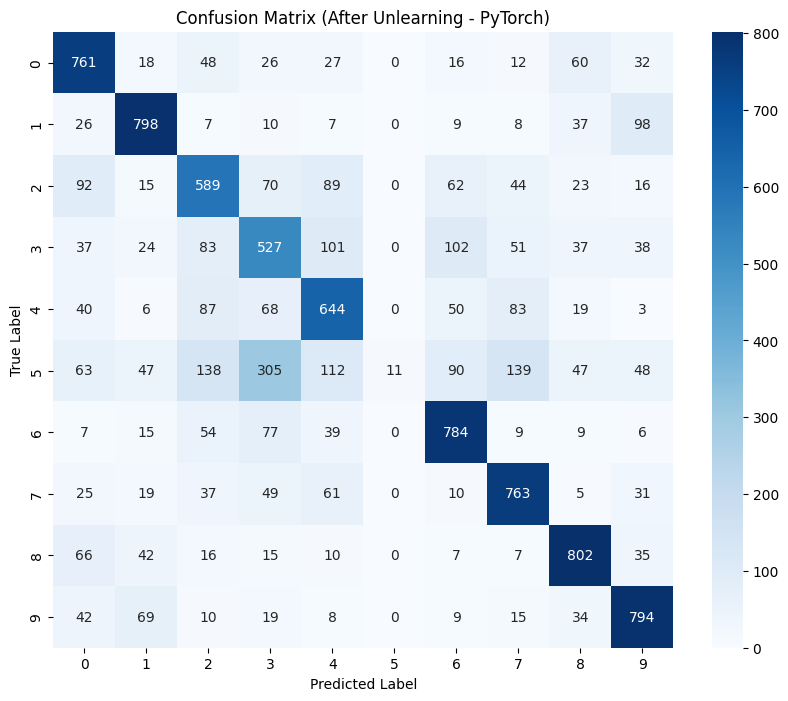


Evaluation complete. Check the classification report and confusion matrix.
Pay attention to the row/column corresponding to class 5.


In [ ]:
print("\n--- Evaluating Unlearned Model ---")

model1.eval() # Set model to evaluation mode
all_preds = []
all_labels = []
with torch.no_grad(): # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model1(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy()) # Move predictions to CPU and store
        all_labels.extend(labels.cpu().numpy())   # Move labels to CPU and store

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate overall metrics using sklearn
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(NUM_CLASSES)])
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Overall Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# Analyze performance specifically for the unlearned class
class_7_indices_test = np.where(all_labels == CLASS_TO_UNLEARN)[0]
if len(class_7_indices_test) > 0:
    y_test_class_7 = all_labels[class_7_indices_test]
    y_pred_class_7 = all_preds[class_7_indices_test]
    accuracy_class_7 = accuracy_score(y_test_class_7, y_pred_class_7)
    print(f"\nAccuracy specifically for class {CLASS_TO_UNLEARN}: {accuracy_class_7:.4f}")
    print(f"(Expected to be low if unlearning was successful)")
else:
    print(f"\nNo samples of class {CLASS_TO_UNLEARN} found in the test set for specific evaluation.")


# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (After Unlearning - PyTorch)')
plt.show()

print("\nEvaluation complete. Check the classification report and confusion matrix.")
print(f"Pay attention to the row/column corresponding to class {CLASS_TO_UNLEARN}.")